In [19]:
import uproot
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
fp_cocoa = 'path to train_skim_seg_bw0.4.root'
fp_clic  = 'path to train_p8_ee_qq_ecm380_150k_100MevCut_inclSingleNode_bw0.3.root'

tree_cocoa = uproot.open(fp_cocoa)['EventTree']
tree_clic  = uproot.open(fp_clic)['EventTree']

data_cocoa = {
    'topo2particle_topo_idx'    : tree_cocoa['topo2particle_topo_idx'].array(library='np'),
    'topo2particle_particle_idx': tree_cocoa['topo2particle_particle_idx'].array(library='np'),
    'topo2particle_energy'      : tree_cocoa['topo2particle_energy'].array(library='np'),
    'particle_pt'               : tree_cocoa['particle_pt'].array(library='np'),
    'track_particle_idx'        : tree_cocoa['track_particle_idx'].array(library='np'),
    'topo_eta'                  : tree_cocoa['topo_eta'].array(library='np'),
}

data_clic = {
    'topo2particle_topo_idx'    : tree_clic['topo2particle_topo_idx'].array(library='np'),
    'topo2particle_particle_idx': tree_clic['topo2particle_particle_idx'].array(library='np'),
    'topo2particle_energy'      : tree_clic['topo2particle_energy'].array(library='np'),
    'particle_pt'               : tree_clic['particle_pt'].array(library='np'),
    'track_particle_idx'        : tree_clic['track_particle_idx'].array(library='np'),
    'topo_eta'                  : tree_clic['topo_eta'].array(library='np'),
}

In [7]:
data_cocoa['n_tracks'] = np.array([len(t) for t in data_cocoa['track_particle_idx']])
data_cocoa['n_topos'] = np.array([len(t) for t in data_cocoa['topo_eta']])
data_cocoa['n_nodes'] = np.array([x + y for x, y in zip(data_cocoa['n_tracks'], data_cocoa['n_topos'])])
data_cocoa['n_particles'] = np.array([len(p) for p in data_cocoa['particle_pt']])

data_clic['n_tracks'] = np.array([len(t) for t in data_clic['track_particle_idx']])
data_clic['n_topos'] = np.array([len(t) for t in data_clic['topo_eta']])
data_clic['n_nodes'] = np.array([x + y for x, y in zip(data_clic['n_tracks'], data_clic['n_topos'])])
data_clic['n_particles'] = np.array([len(p) for p in data_clic['particle_pt']])

### Incidence computation

- Ignore the tracks completely

In [14]:
def get_incidence_matrix(data_dict, idx):
    max_particles = 60

    # incidence_matrix = np.zeros((max_particles, data_dict['n_nodes'][idx]))
    incidence_matrix = np.zeros((max_particles, data_dict['n_topos'][idx]))

    # # add tracks
    # part_idxs = data_dict['track_particle_idx'][idx]
    # track_idxs = np.arange(data_dict['n_tracks'][idx])
    # incidence_matrix[part_idxs, track_idxs] = 1.0

    # add topos
    topo_idxs = data_dict['topo2particle_topo_idx'][idx]
    part_idxs = data_dict['topo2particle_particle_idx'][idx]
    part_es = data_dict['topo2particle_energy'][idx]
    # incidence_matrix[part_idxs, topo_idxs + data_dict['n_tracks'][idx]] = part_es
    incidence_matrix[part_idxs, topo_idxs] = part_es

    # check for TC w/o associated particles
    if (incidence_matrix.sum(axis=0) == 0).any():
        noisy_cols = np.where(incidence_matrix.sum(axis=0) == 0)[0]
        fake_rows  = np.arange(len(noisy_cols)) + data_dict['n_particles'][idx]

        # check for indices greater than config_v['max_particles']
        if not (fake_rows < max_particles).all():
            print(f'Warning: fake_rows go beyond maximum ({max_particles}) particles in event {idx}. Dropping them!')
            noisy_cols = noisy_cols[fake_rows < max_particles]
            fake_rows = fake_rows[fake_rows < max_particles]
        incidence_matrix[fake_rows, noisy_cols] = 1.0

    # normalize
    incidence_matrix = incidence_matrix / np.clip(incidence_matrix.sum(axis=0, keepdims=True), a_min=1e-6, a_max=None)

    return incidence_matrix

In [15]:
data_cocoa['incidence_matrix'] = []
for i in tqdm(range(len(data_cocoa['n_nodes']))):
    if data_cocoa['n_nodes'][i] < 2 or data_cocoa['n_particles'][i] > 60:
        continue
    data_cocoa['incidence_matrix'].append(get_incidence_matrix(data_cocoa, i))

  0%|          | 0/1624349 [00:00<?, ?it/s]

In [16]:
data_clic['incidence_matrix'] = []
for i in tqdm(range(len(data_clic['n_nodes']))):
    if data_clic['n_nodes'][i] < 2 or data_clic['n_particles'][i] > 60:
        continue
    data_clic['incidence_matrix'].append(get_incidence_matrix(data_clic, i))

  0%|          | 0/3454324 [00:00<?, ?it/s]

### Plotting

In [21]:
bins = np.linspace(0.01, 1, 25)

inc_hist_cocoa = np.histogram(np.hstack(data_cocoa['incidence_matrix']), bins=bins, density=True)[0]
inc_hist_clic = np.histogram(np.hstack(data_clic['incidence_matrix']), bins=bins, density=True)[0]

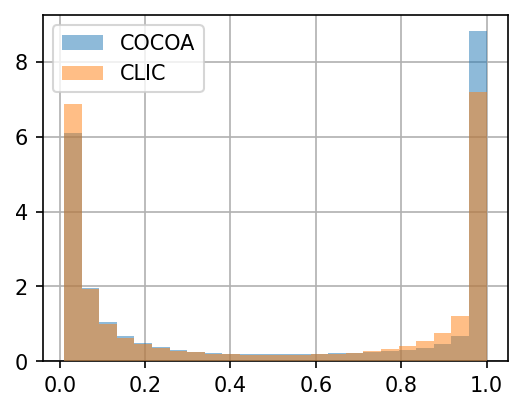

In [25]:
fig = plt.figure(figsize=(4, 3), dpi=150)
gs = fig.add_gridspec(1, 1)

bin_mids = (bins[1:] + bins[:-1]) / 2

ax = fig.add_subplot(gs[0, 0])
ax.bar(bin_mids, inc_hist_cocoa, width=np.diff(bins), alpha=0.5, label='COCOA', zorder=5)
ax.bar(bin_mids, inc_hist_clic, width=np.diff(bins), alpha=0.5, label='CLIC', zorder=5)
ax.legend()
ax.grid(True)